In [1]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import xgboost as xgb
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('supermarket_sales - Sheet1.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Total                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

In [5]:
# Handiling the Date and Time
df['Datetime'] = df['Date']+''+df['Time']
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating,Datetime
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1,1/5/201913:08
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6,3/8/201910:29
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4,3/3/201913:23
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4,1/27/201920:33
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3,2/8/201910:37


In [6]:
#Extract datetime feature
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time']) # Convert to datetime using pd.to_datetime

df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
df['hour'] = df['Datetime'].dt.hour
df['minute'] = df['Datetime'].dt.minute
#Drop the orginal column
df.drop(columns=['Date','Time',],inplace=True)
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,...,cogs,gross margin percentage,gross income,Rating,Datetime,year,month,day,hour,minute
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,...,522.83,4.761905,26.1415,9.1,2019-01-05 13:08:00,2019,1,5,13,8
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,...,76.40,4.761905,3.8200,9.6,2019-03-08 10:29:00,2019,3,8,10,29
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,...,324.31,4.761905,16.2155,7.4,2019-03-03 13:23:00,2019,3,3,13,23
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,...,465.76,4.761905,23.2880,8.4,2019-01-27 20:33:00,2019,1,27,20,33
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,...,604.17,4.761905,30.2085,5.3,2019-02-08 10:37:00,2019,2,8,10,37


In [7]:
# Sort by datetime
df = df.sort_values('Datetime')

# Set datetime as index
df.set_index('Datetime', inplace=True)

# Check time delta
time_deltas = df.index.to_series().diff()
print(time_deltas.value_counts().head())  # Check if regular interval


Datetime
0 days 00:09:00    20
0 days 00:03:00    20
0 days 00:24:00    19
0 days 00:43:00    18
0 days 00:34:00    17
Name: count, dtype: int64


In [8]:
# handling missing data
df.interpolate(method='linear', inplace=True)


<ipython-input-8-58cea18fe106>:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [9]:
# Drop rows with still-missing values if any
df.dropna(inplace=True)



In [10]:
# Check time difference between rows
time_deltas = df.index.to_series().diff()

# Display the most common time difference
print(time_deltas.value_counts())


Datetime
0 days 00:09:00    20
0 days 00:03:00    20
0 days 00:24:00    19
0 days 00:43:00    18
0 days 00:34:00    17
                   ..
0 days 13:37:00     1
0 days 16:08:00     1
0 days 15:36:00     1
0 days 14:57:00     1
0 days 01:28:00     1
Name: count, Length: 258, dtype: int64


In [11]:
# Resample to daily data (mean aggregation)
# Exclude 'Invoice ID' column from the mean calculation
df = df.resample('D').agg({'Invoice ID': 'first', 'Branch': 'first', 'City': 'first', 'Customer type': 'first', 'Gender': 'first', 'Product line': 'first', 'Unit price': 'mean', 'Quantity': 'mean', 'Tax 5%': 'mean', 'Total': 'mean', 'Payment': 'first', 'cogs': 'mean', 'gross margin percentage': 'mean', 'gross income': 'mean', 'Rating': 'mean', 'year': 'first', 'month': 'first', 'day': 'first', 'hour': 'mean', 'minute': 'mean'}).interpolate()


<ipython-input-11-8cc360ada9eb>:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('D').agg({'Invoice ID': 'first', 'Branch': 'first', 'City': 'first', 'Customer type': 'first', 'Gender': 'first', 'Product line': 'first', 'Unit price': 'mean', 'Quantity': 'mean', 'Tax 5%': 'mean', 'Total': 'mean', 'Payment': 'first', 'cogs': 'mean', 'gross margin percentage': 'mean', 'gross income': 'mean', 'Rating': 'mean', 'year': 'first', 'month': 'first', 'day': 'first', 'hour': 'mean', 'minute': 'mean'}).interpolate()


In [14]:
# Create datetime features
df['Day_of_week'] = df.index.dayofweek
df['Month'] = df.index.month


In [15]:
df['Sales_log_1'] = np.log1p(df['Total'].shift(1))
df['rolling_mean_7'] = df['Total'].shift(1).rolling(window=7).mean()
df = df.dropna()


In [16]:
features = ['Sales_log_1', 'rolling_mean_7', 'Day_of_week', 'Month']
X = df[features]
y = df['Total']


In [17]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
#Reduce Noise using Random Forest
rfr_smoother = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_smoother.fit(X_scaled, y)
y_smoothed = rfr_smoother.predict(X_scaled)


In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_smoothed, test_size=0.2, shuffle=False)


In [20]:
#train the random forest
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [21]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.fc(x).squeeze(-1)


In [24]:
#hyperprameter tuning
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['xgb', 'transformer'])

    if model_type == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('lr', 0.01, 0.3),
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test) # Predict on X_test for evaluation
    else:
        d_model = trial.suggest_int("d_model", 32, 128)
        # Ensure nhead is a divisor of d_model
        nhead = trial.suggest_int("nhead", 2, min(8, d_model // 2), step=2)  # Ensure nhead is a divisor of d_model
        # Make sure d_model is divisible by nhead
        d_model = (d_model // nhead) * nhead  # Adjust d_model to be divisible by nhead
        num_layers = trial.suggest_int("num_layers", 1, 4)
        dropout = trial.suggest_float("dropout", 0.0, 0.3)

        model = TransformerRegressor(len(features), d_model, nhead, num_layers, dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()

        # Directly convert X_train to a PyTorch tensor without .values
        X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
        y_train_torch = torch.tensor(y_train, dtype=torch.float32)
        X_test_torch = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

        for epoch in range(10):  # light training for tuning
            model.train()
            optimizer.zero_grad()
            output = model(X_train_torch) # Use training data for training
            loss = loss_fn(output, y_train_torch)
            loss.backward()
            optimizer.step()

        model.eval()
        preds = model(X_test_torch).detach().numpy() # Use test data for prediction and evaluation


    return mean_squared_error(y_test, preds) # Calculate MSE using y_test and predictions on X_test

In [25]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
print("Best model:", study.best_params)


[I 2025-04-20 07:06:27,530] A new study created in memory with name: no-name-afde488b-6e52-4b75-9402-4eaa274de159
[I 2025-04-20 07:06:27,585] Trial 0 finished with value: 1552.5584083233748 and parameters: {'model_type': 'xgb', 'n_estimators': 128, 'max_depth': 8, 'lr': 0.18470570066855074}. Best is trial 0 with value: 1552.5584083233748.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2025-04-20 07:06:28,025] Trial 

Best model: {'model_type': 'xgb', 'n_estimators': 55, 'max_depth': 4, 'lr': 0.23385954952291083}


In [33]:
best_params = study.best_trial.params


In [36]:
if best_params['model_type'] == 'xgb':
    final_model = xgb.XGBRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['lr']
    )
    final_model.fit(X_train, y_train)
elif best_params['model_type'] == 'transformer':
    d_model = best_params['d_model']
    nhead = best_params['nhead']
    d_model = (d_model // nhead) * nhead
    num_layers = best_params['num_layers']
    dropout = best_params['dropout']

    final_model = TransformerRegressor(len(features), d_model, nhead, num_layers, dropout)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32)

    for epoch in range(100):  # More serious training
        final_model.train()
        optimizer.zero_grad()
        output = final_model(X_train_torch)
        loss = loss_fn(output, y_train_torch)
        loss.backward()
        optimizer.step()


In [37]:
#Forecast Next 7 Days
import datetime

last_date = df.index.max()
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 8)]
future_df = pd.DataFrame({'Datetime': future_dates})

# Generate datetime features
future_df['Day_of_week'] = future_df['Datetime'].dt.dayofweek
future_df['Month'] = future_df['Datetime'].dt.month

# Fill with last known values for lag features
last_known = df.iloc[-1]
future_df['Sales_log_1'] = last_known['Sales_log_1']
future_df['rolling_mean_7'] = last_known['rolling_mean_7']

# Prepare input
future_df.set_index('Datetime', inplace=True)
X_future = scaler.transform(future_df[features])

# Forecast
forecasted_values = model.predict(X_future)


In [38]:
# future_df['Predicted_Total'] = forecast
# # Reset the index to make 'Datetime' a column again
# future_df = future_df.reset_index()
# print(future_df[['Datetime', 'Predicted_Total']])

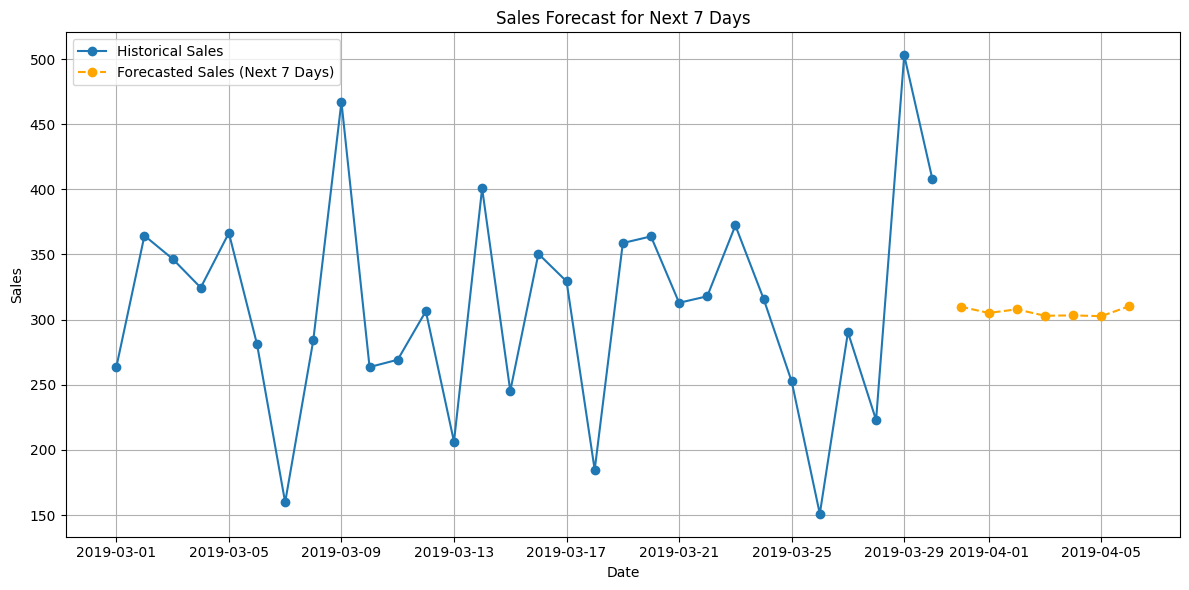

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-30:], y[-30:], label='Historical Sales', marker='o')
plt.plot(future_df.index, forecasted_values, label='Forecasted Sales (Next 7 Days)', color='orange', marker='o', linestyle='--')
plt.title('Sales Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


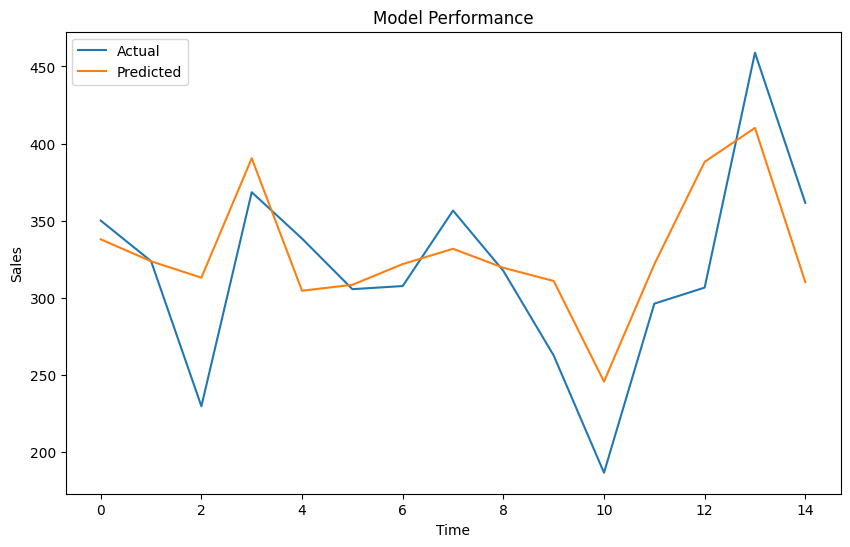

In [40]:

#Plot the model's performance
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Model Performance')
plt.legend()
plt.show()
